In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root_dir = r"D:\Studying\UoR\1. Data Mining\Final_Project\data"

In [5]:
for file_name in os.listdir(root_dir):
    file_path = os.path.join(root_dir, file_name)
    
    if os.path.isdir(file_path):
        continue
    
    df = pd.read_csv(file_path)
    df.drop_duplicates("url", inplace=True)
    df.to_csv(file_path, index=None)
    print(f"{file_name} has {df.shape[0]} examples")

ap_canada.csv has 599 examples
ap_china.csv has 600 examples
ap_russia.csv has 600 examples
cbc.csv has 1546 examples
china_daily.csv has 8728 examples
global-news.csv has 11072 examples
moscow_times.csv has 13572 examples
reuters_canada.csv has 4365 examples
reuters_china.csv has 2736 examples
reuters_russia.csv has 5845 examples


## Reuters News

### Canada

In [3]:
file_path = os.path.join(root_dir, "reuters_canada.csv")
df = pd.read_csv(file_path)
df.shape

(4233, 16)

In [4]:
df.columns

Index(['authors', 'date_download', 'date_modify', 'date_publish',
       'description', 'filename', 'image_url', 'language', 'localpath',
       'maintext', 'source_domain', 'text', 'title', 'title_page', 'title_rss',
       'url'],
      dtype='object')

In [5]:
df.fillna("", inplace=True)

#### Cleaning

#### Reporting By

Reuters `maintext` column always contains the section **Reporting by**. Which isn't a part of the news maintext. Instead it should be a part of a separate column.

In [6]:
import re

def find_last_instance(text, phrase):
    matches = [match for match in re.finditer(phrase, text)]
    
    if matches:
        last_match = matches[-1]
        return last_match.start(), last_match.end()
    else:
        return None
    
def discard_reporting_by(text):
    position = find_last_instance(text, "Reporting by")
    
    if position is None:
        return text
    
    return text[:position[0]]

In [7]:
df.maintext = df.maintext.apply(discard_reporting_by)

In [8]:
df.maintext.iloc[0]

'A mural features the image of late Sikh leader Hardeep Singh Nijjar, who was slain on the grounds of the Guru Nanak Sikh Gurdwara temple in June 2023, in Surrey, British Columbia, Canada September 18, 2023. REUTERS/Chris Helgren/file photo Acquire Licensing Rights\nNEW DELHI, Sept 19 (Reuters) - Trade talks between India and Canada have taken a hit as tension rises after Prime Minister Justin Trudeau said authorities were investigating "credible allegations" linking New Delhi\'s agents to the murder of Sikh separatist leader, Hardeep Singh Nijjar.\nOn Tuesday, New Delhi dismissed the allegations as "absurd", and asked Canada instead to crack down on anti-India elements operating in its territory.\nHere is what is at stake for both countries:\nHOW ARE TRADE TALKS AFFECTED?\nCanada said this month it had paused talks on the proposed treaty with India, just three months after both said they aimed to seal an initial pact this year.\nIndustry estimates show the Comprehensive Economic Partn

#### Links

Remove hyperlinks from maintext.

In [9]:
def remove_links(text):
    return re.sub(r'http\S+|www.\S+', '', text)

text = "Your text goes here... https://www.bing.com/search?q=Bing+AI&showconv=1&FORM=hpcodx"
text_without_links = remove_links(text)
print(text_without_links)

Your text goes here... 


In [10]:
df.maintext = df.maintext.apply(remove_links)

#### Removing **Stories Read More**

In [11]:
re.sub("STORIES: read more", "", "Before words\nSTORIES: read more\nAfter words")

'Before words\n\nAfter words'

In [12]:
df.maintext = df.maintext.apply(lambda x: re.sub("STORIES: read more\n", "", x))

#### Removing Initial Location and Date Info

In [13]:
def find_first_instance(text, phrase):
    matches = [match for match in re.finditer(phrase, text)]
    
    if matches:
        last_match = matches[-1]
        return last_match.start(), last_match.end()
    else:
        return None
    
def discard_initial_location_and_date(text):
    position = find_last_instance(text, "\(Reuters\) - ")
    
    if position is None:
        return text
    
    return text[position[1]:]

discard_initial_location_and_date(df.maintext.iloc[0])

'Trade talks between India and Canada have taken a hit as tension rises after Prime Minister Justin Trudeau said authorities were investigating "credible allegations" linking New Delhi\'s agents to the murder of Sikh separatist leader, Hardeep Singh Nijjar.\nOn Tuesday, New Delhi dismissed the allegations as "absurd", and asked Canada instead to crack down on anti-India elements operating in its territory.\nHere is what is at stake for both countries:\nHOW ARE TRADE TALKS AFFECTED?\nCanada said this month it had paused talks on the proposed treaty with India, just three months after both said they aimed to seal an initial pact this year.\nIndustry estimates show the Comprehensive Economic Partnership Agreement (CEPA) between Canada and India could boost two-way trade by as much as $6.5 billion, yielding a GDP gain of $3.8 billion to $5.9 billion for Canada by 2035.\nWHAT ARE THE KEY ITEMS OF TRADE?\nSteady growth has seen goods trade rising to $8 billion in 2022, with Indian exports to

In [14]:
df.maintext = df.maintext.apply(discard_initial_location_and_date)

#### Removing **Annual Inflation Rate** news

These news contain very little textual information.

In [15]:
df.shape

(4233, 16)

In [17]:
temp = df.title.apply(lambda x: x.find("annual inflation rate") != -1)
df.drop(df[temp].index, inplace=True)

#### Contains At Least One Geographic Name

In [19]:
frequent_words = ["Canada", "Alberta", "Montreal", "Toronto", "British Columbia", 
                "Saskatchewan", "Quebec", "Ontario", "Manitoba", "Newfoundland", 
                "Yukon", "Canadian"]

In [20]:
def includes_words(text):
    for word in frequent_words:
        if word in text.split():
            return True
        
    return False

In [21]:
temp = df.maintext.apply(includes_words)
df.drop(df[~temp].index, inplace=True)

#### Count

##### Letters

In [22]:
temp = df.loc[:, ["maintext", "title"]]\
    .apply(lambda row: [len(col) for col in row])
temp.describe()

,maintext,title
count,4044.000000,4044.00000
mean,1921.374876,63.19634
std,995.002823,11.31137
min,214.000000,28.00000
25%,1419.750000,55.00000
50%,1765.000000,63.00000
75%,2310.250000,71.00000
max,9527.000000,110.00000


Number of examples that have zero length main and title text

In [23]:
temp.apply(lambda row: [col == 0 for col in row]).sum()

maintext    0
title       0
dtype: int64

Drop the zero length maintext and title rows from dataframe.

In [24]:
cond = (temp.title <= 0) | (temp.maintext <= 0)
df.drop(temp[cond].index, inplace=True)

##### Words

In [25]:
temp = df.loc[:, ["maintext", "title"]]\
    .apply(lambda row: [len(col.split()) for col in row])
temp.describe()

,maintext,title
count,4044.000000,4044.000000
mean,310.064293,10.011375
std,161.078574,1.865598
min,32.000000,4.000000
25%,229.000000,9.000000
50%,288.000000,10.000000
75%,370.250000,11.000000
max,1550.000000,17.000000


Drop rows where number of words are either too low or too high. These are outliers.

In [26]:
def outliers(temp):
    q1 = np.quantile(temp, 0.25)
    q3 = np.quantile(temp, 0.75)
    iqr = q3 - q1
    span = 1.5 * iqr
    low = np.floor(q1 - span)
    high = np.ceil(q3 + span)
    return (temp < low) | (temp > high)

main_to_drop = outliers(temp.maintext)
title_to_drop = outliers(temp.title)
cond = main_to_drop | title_to_drop
df.drop(temp[cond].index, inplace=True)
df.shape

(3745, 16)

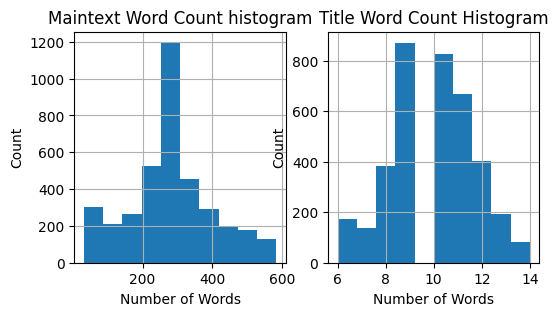

In [27]:
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
temp[~cond].maintext.hist()
plt.title("Maintext Word Count histogram")
plt.xlabel("Number of Words")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
temp[~cond].title.hist()
plt.title("Title Word Count Histogram")
plt.xlabel("Number of Words")
plt.ylabel("Count")

plt.show()

#### Save Cleaned Data

In [28]:
CLEANED_ROOT_PATH = os.path.join(root_dir, "cleaned")
df.to_csv(os.path.join(CLEANED_ROOT_PATH, "reuters_canada.csv"), index=False)

## Moscow Times

In [5]:
file_path = os.path.join(root_dir, "moscow_times.csv")
df = pd.read_csv(file_path, usecols=["title", "maintext", "date_publish"])
df.shape

(13572, 3)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13572 entries, 0 to 13571
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date_publish  13572 non-null  object
 1   maintext      13572 non-null  object
 2   title         13572 non-null  object
dtypes: object(3)
memory usage: 318.2+ KB


In [29]:
from datetime import datetime
from collections import defaultdict

In [30]:
dict = defaultdict(list)

for file_name in os.listdir(root_dir):
    file_path = os.path.join(root_dir, file_name)
    df = pd.read_csv(file_path)
    root_name = file_name.split(".")[0]
    
    df.date_publish.fillna("", inplace=True)
    time = df.date_publish.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S") if x else "")
    time = time.apply(lambda x: x.year).value_counts()
    
    print(root_name)
    print(time)

ap_canada
2023    459
2022    140
Name: date_publish, dtype: int64
ap_china
2023    600
Name: date_publish, dtype: int64
ap_russia
2023    599
2022      1
Name: date_publish, dtype: int64


d:\Studying\UoR\1. Data Mining\Final_Project\venv\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  if __name__ == "__main__":


cbc
2023.0    514
2021.0    339
2022.0    166
2019.0    146
2020.0     80
2015.0     22
2017.0     10
2016.0      9
2018.0      8
2014.0      4
2013.0      2
2011.0      1
2007.0      1
Name: date_publish, dtype: int64
china_daily
2017.0    2023
2018.0    1833
2019.0    1239
2021.0    1066
2020.0     921
2023.0     861
2022.0     770
2014.0       1
Name: date_publish, dtype: int64


PermissionError: [Errno 13] Permission denied: 'D:\\Studying\\UoR\\1. Data Mining\\Final_Project\\data\\cleaned'

In [ ]:
file_path = r"D:\Studying\UoR\1. Data Mining\Final_Project\data\global-news.csv"
df = pd.read_csv(file_path)
df.shape

(6365, 16)

In [ ]:
df.date_publish.sample(10)

2136    2023-09-20 14:12:59
4324    2023-06-22 10:07:15
6165    2023-06-08 12:55:47
3037    2023-08-31 14:00:14
2606    2023-09-07 18:21:17
724     2023-09-21 12:01:59
5187    2023-06-02 12:09:22
522     2023-10-09 20:57:33
5128    2023-06-30 15:16:41
334     2023-10-13 10:00:17
Name: date_publish, dtype: object

In [ ]:
df.date_publish.fillna("", inplace=True)

In [ ]:
time = df.date_publish.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S") if x else "")

In [ ]:
x = time.apply(lambda x: x.year).value_counts().to_dict()
# x.index
# x.values
x

{2017.0: 2023,
 2018.0: 1833,
 2019.0: 1239,
 2021.0: 1066,
 2020.0: 921,
 2023.0: 861,
 2022.0: 770,
 2014.0: 1}

In [ ]:
df.sample(3)

,authors,date_download,date_modify,date_publish,description,filename,image_url,language,localpath,maintext,source_domain,text,title,title_page,title_rss,url
2743,"['Alex Cooke', 'Global News']",2023-11-18 22:56:05,NaN,2023-08-01 12:01:38,Tuesday marked the third annual Emancipation D...,https%3A%2F%2Fglobalnews.ca%2Fnews%2F9869530%2...,https://globalnews.ca/wp-content/uploads/2022/...,en,NaN,Send this page to someone via email\nTuesday m...,globalnews.ca,NaN,Emancipation Day in N.S.: A time to reflect on...,NaN,NaN,https://globalnews.ca/news/9869530/ns-emancipa...
1039,"['Sam Thompson', 'Global News']",2023-11-18 22:18:42,NaN,2023-11-10 11:37:11,Winnipeg police say a 28-year-old woman faces ...,https%3A%2F%2Fglobalnews.ca%2Fnews%2F10084459%...,https://globalnews.ca/wp-content/uploads/2023/...,en,NaN,Send this page to someone via email\nA 28-year...,globalnews.ca,NaN,Winnipeg hockey coach faces 15 charges in sexu...,NaN,NaN,https://globalnews.ca/news/10084459/winnipeg-c...
1810,"['Greg Davis', 'Global News']",2023-11-18 22:35:22,NaN,2023-09-29 10:50:50,A diesel fuel spill in September 2020 entered ...,https%3A%2F%2Fglobalnews.ca%2Fnews%2F9994362%2...,https://globalnews.ca/wp-content/uploads/2023/...,en,NaN,Send this page to someone via email\nA tractor...,globalnews.ca,NaN,"Walmart, trailer rental company fined $155K fo...",NaN,NaN,https://globalnews.ca/news/9994362/walmart-tra...
